# Preprocesamiento

In [214]:
from t2_flujo import *
import folium
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
# CODIGO QUE LA AYUDANTE PUSO EN EL PPT
north = -41.4
south = -41.496
east = -72.85
west = -73.03
G0 = ox.graph_from_bbox(north,south,east,west,network_type='drive')

In [4]:
# CON ESTO PUEDO GRAFICAR PUERTO MONTT
'''ox.folium.plot_graph_folium(G0, tiles='CartoDB positron', color='red', weight=1)'''

"ox.folium.plot_graph_folium(G0, tiles='CartoDB positron', color='red', weight=1)"

In [5]:
# elimino los arcos paralelos, esto con el codigo que puso la ayudante
G = G0.copy()
duplicated = []
for u,v,a in G.edges(data=True):
    if len(G[u][v]) == 2:
        duplicated.append((u,v,1))
    elif len(G[u][v]) == 3:      
        duplicated.append((u,v,1))
        duplicated.append((u,v,2))
duplicated = list(dict.fromkeys(duplicated))

G.remove_edges_from(duplicated)

In [6]:
# matriz_costos_df tiene el costo de un nodo a otro

In [7]:
# esto lo encontre de casulidad, da los nodos "adyacentes"
# de otro nodo
# [(n, nbrdict) for n, nbrdict in G.adjacency()]
#print(nx.adjacency_matrix(G).toarray())

In [9]:
# ESTO GRAFICA EL MAPA DE PTO MONTT Y PONE LOS NODOS DE PRODUCCION, BODEGA Y DEMANDA
colores = {'demanda':'blue','bodega':'green','produccion':'black'}
m=ox.folium.plot_graph_folium(G0, tiles='CartoDB positron', color='red', weight=1)
for i in range(len(nodos_totales)):
    nodo = nodos_totales.loc[i]
    x = nodo['x']
    y = nodo['y']
    tipo = nodo['tipo']
    folium.CircleMarker(location=[y, x], color = colores[tipo], radius=5, fill = True, fill_opacity = 10).add_to(m)
m

"colores = {'demanda':'blue','bodega':'green','produccion':'black'}\nm=ox.folium.plot_graph_folium(G0, tiles='CartoDB positron', color='red', weight=1)\nfor i in range(len(nodos_totales)):\n    nodo = nodos_totales.loc[i]\n    x = nodo['x']\n    y = nodo['y']\n    tipo = nodo['tipo']\n    folium.CircleMarker(location=[y, x], color = colores[tipo], radius=5, fill = True, fill_opacity = 10).add_to(m)\nm"

In [289]:
# ELIMINA LOS ARCOS QUE NO SIRVEN PARA MODELAR EL PROBLEMA

# list(grafo_vial.edges(data=True))[par][origen/destino]
grafo_vial_nuevo = grafo_vial.copy()
lista_pares_nodos = list(grafo_vial_nuevo.edges())

for b in range(len(lista_pares_nodos)):
    a = lista_pares_nodos[b]
    
    O = nodos_totales[nodos_totales['id_nodo'] == a[0]]
    O_pos = O.index[0]

    D = nodos_totales[nodos_totales['id_nodo'] == a[1]]
    D_pos = D.index[0]

    if O['tipo'][O_pos] == D['tipo'][D_pos]:
        grafo_vial_nuevo.remove_edge(O['id_nodo'][O_pos],D['id_nodo'][D_pos])
    
    elif O['tipo'][O_pos] == 'demanda':
        grafo_vial_nuevo.remove_edge(O['id_nodo'][O_pos], D['id_nodo'][D_pos])

In [337]:
# ESTO ENCUENTRAS LAS RUTAS MINIMAS ENTRE CUALQUIER PAR DE NODOS, DA IGUAL SI ES PRODUCCION, ALMACENAJE O DEMANDA
# N son las rutas minimas de los N-primeros arcos del grafo (de los 1,2...,n arcos)

def rutas_min(grafo: nx.Graph, grafo_ciudad: nx.Graph, N: int):
    lista_pares_nodos = list(grafo.edges())
    dict_info_nodos = dict(grafo_ciudad.nodes(data=True))

    rutas = []
    distancias = []

    for par in range(N):
        parcito = lista_pares_nodos[par]
        O = parcito[0]
        D = parcito[1]

        x_O = dict_info_nodos[O]['x']
        y_O = dict_info_nodos[O]['y']
        
        x_D = dict_info_nodos[D]['x']
        y_D = dict_info_nodos[D]['y']
        
        origen = ox.distance.nearest_nodes(grafo_ciudad, x_O, y_O)
        destino = ox.distance.nearest_nodes(grafo_ciudad, x_D, y_D)

        r = nx.shortest_path(grafo_ciudad, origen, destino, weight='cost')
        d = nx.shortest_path_length(grafo_ciudad, origen, destino, weight='distance')
        rutas.append(r)
        distancias.append(d)
    
    # rutas son las rutas min, distancias es el largo de la ruta
    return (rutas,distancias)

In [338]:
# la funcion que grafica rutas minimas
def graficar_rutas_min_n(rutas: list, grafo, N):
    m2 = ox.folium.plot_graph_folium(grafo.subgraph(rutas[0]), tiles='CartoDB positron', weight= 2)
    for a in range(1, N):
        ox.folium.plot_graph_folium(grafo.subgraph(rutas[a]) , graph_map = m2, tiles='CartoDB positron', weight= 2)

    # Guardar mapa como html
    map_file2 = 'Mapa de prueba.html'
    m2.save(map_file2)
    print(f"Mapa guardado en {map_file2}")
    
    return m2

In [341]:
# asi quedan algunos arcos del grafo
r_min = rutas_min(grafo_vial_nuevo, G, 100)
r_min[0]
graficar_rutas_min_n(r_min[0], G, 100)

Mapa guardado en Mapa de prueba.html


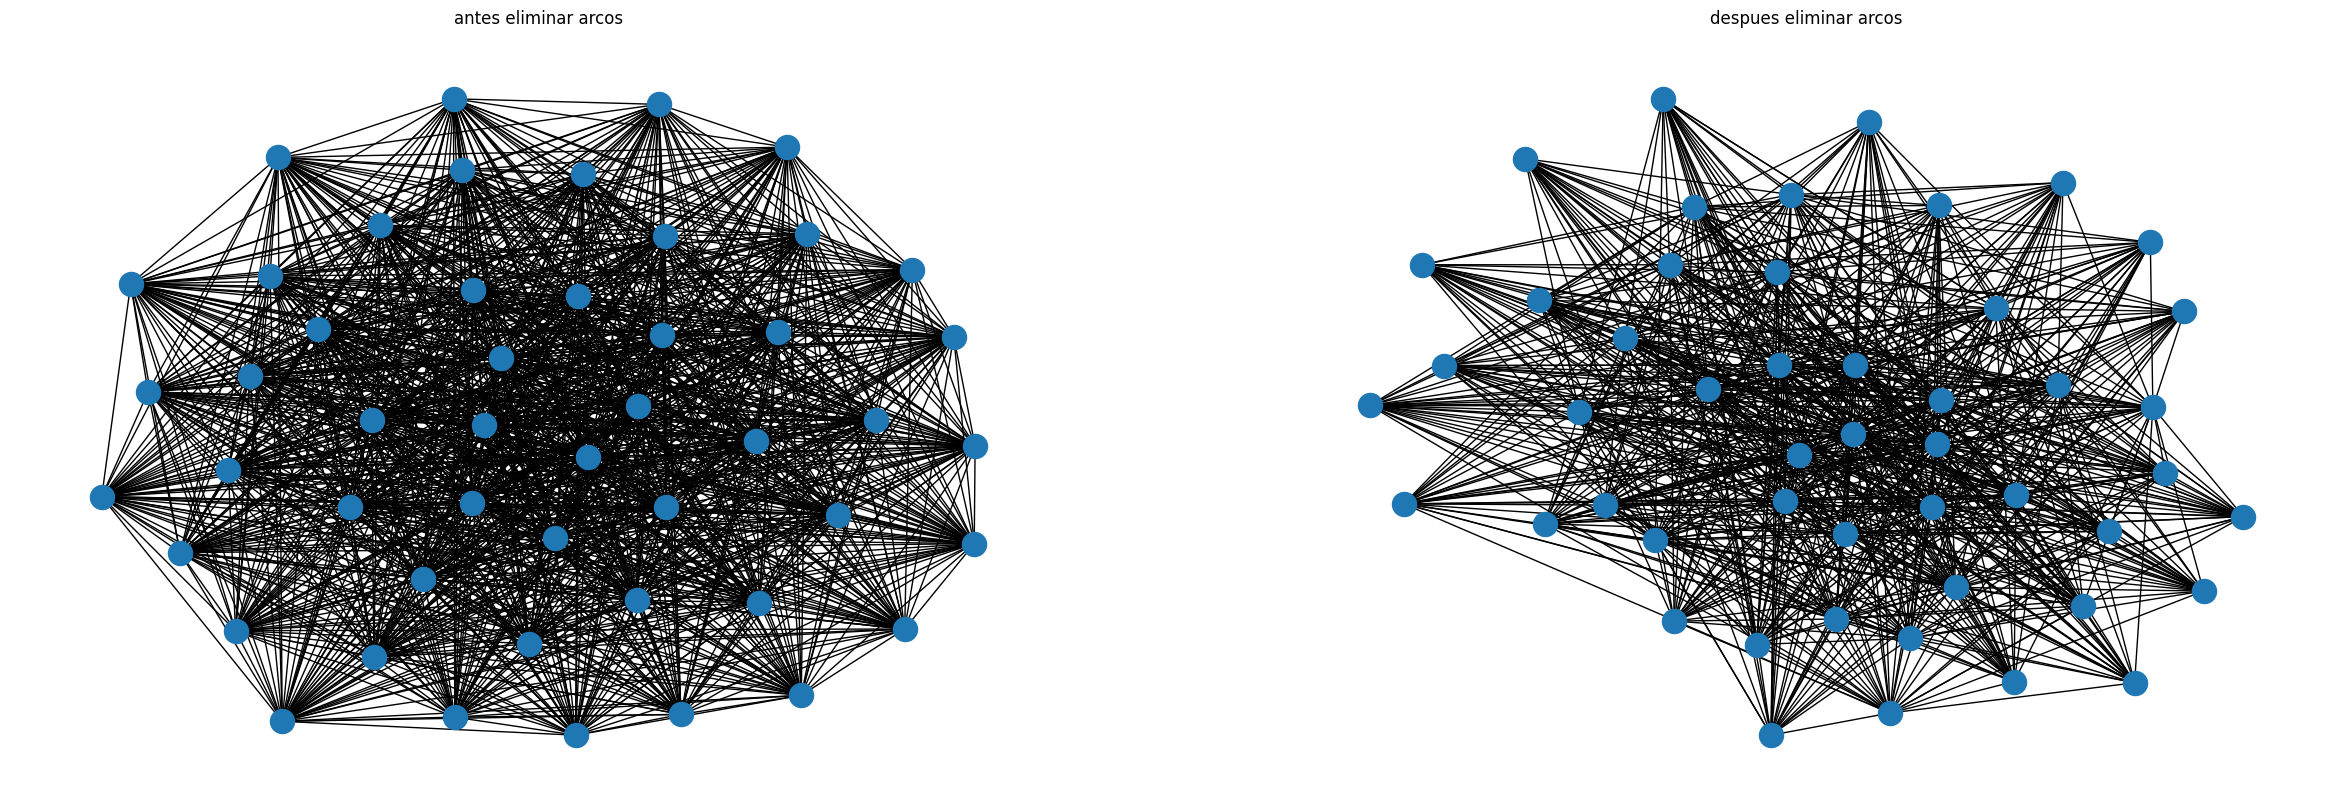

In [290]:
# ESTO ES SOLO PARA VER LOS ARCOS ELIMINADOS
plt.subplots(1,2, figsize = (30,10))

plt.subplot(1,2,1)
plt.title('antes eliminar arcos')
nx.draw(grafo_vial)

plt.subplot(1,2,2)
plt.title('despues eliminar arcos')
nx.draw(grafo_vial_nuevo)